In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
import numpy as np
import os
import torch



random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, 2)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100, 200)
        self.fc4 = nn.Linear(200, 400)
        self.fc5 = nn.Linear(400, 784)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x 

In [2]:
import torch.nn.functional as F
batch_size = 64
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
root = '../datasets'
# 加载数据集
train_dataset =  datasets.MNIST(root, train=True, transform=transforms.ToTensor(), download=True)

# 创建数据加载器
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)

encoder = Encoder().to(device)
decoder = Decoder().to(device)
criterion = F.l1_loss
optimizer = optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr=learning_rate)

# 训练模型
num_epochs = 30
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, _ in train_loader:
        inputs = torch.flatten(inputs, start_dim=-2).to(device) 
        optimizer.zero_grad()
        en_outputs = encoder(inputs)
        de_outputs = decoder(en_outputs)
        loss = criterion(de_outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')




Using cuda device
Epoch [1/30], Average Loss: 0.1125
Epoch [2/30], Average Loss: 0.0975
Epoch [3/30], Average Loss: 0.0918
Epoch [4/30], Average Loss: 0.0881
Epoch [5/30], Average Loss: 0.0854
Epoch [6/30], Average Loss: 0.0840
Epoch [7/30], Average Loss: 0.0823
Epoch [8/30], Average Loss: 0.0814
Epoch [9/30], Average Loss: 0.0809
Epoch [10/30], Average Loss: 0.0798
Epoch [11/30], Average Loss: 0.0792
Epoch [12/30], Average Loss: 0.0789
Epoch [13/30], Average Loss: 0.0784
Epoch [14/30], Average Loss: 0.0780
Epoch [15/30], Average Loss: 0.0775
Epoch [16/30], Average Loss: 0.0773
Epoch [17/30], Average Loss: 0.0774
Epoch [18/30], Average Loss: 0.0771
Epoch [19/30], Average Loss: 0.0763
Epoch [20/30], Average Loss: 0.0763
Epoch [21/30], Average Loss: 0.0766
Epoch [22/30], Average Loss: 0.0762
Epoch [23/30], Average Loss: 0.0758
Epoch [24/30], Average Loss: 0.0758
Epoch [25/30], Average Loss: 0.0758
Epoch [26/30], Average Loss: 0.0754
Epoch [27/30], Average Loss: 0.0753
Epoch [28/30], Aver

In [3]:
# 创建保存模型的目录（如果它还不存在）
model_dir = '../model/mae'
os.makedirs(model_dir, exist_ok=True)

# 保存模型状态字典
torch.save(encoder.state_dict(), os.path.join(model_dir, 'encoder.pth'))
torch.save(decoder.state_dict(), os.path.join(model_dir, 'decoder.pth'))


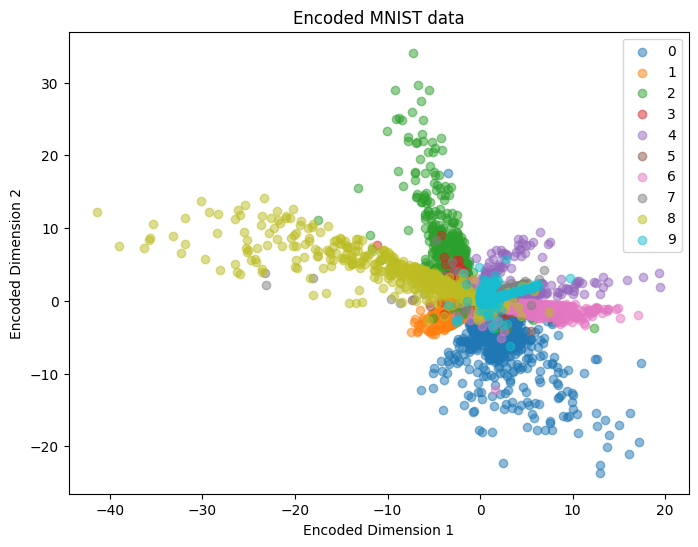

In [4]:
import matplotlib.pyplot as plt
import numpy as np


batch_size = 64
root = '../datasets'
# 加载测试集
test_dataset = datasets.MNIST(root, train=False, transform=transforms.ToTensor(), download=True)

# 创建数据加载器
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

encoder = Encoder()

# 加载模型状态字典
encoder.load_state_dict(torch.load('../model/mae/encoder.pth'))

# 如果您要在GPU上使用模型，请确保将模型转移到GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = encoder.to(device)

# 将模型设置为评估模式
encoder.eval()

# 用于存储编码结果和标签
encoded_images = []
labels_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = torch.flatten(inputs, start_dim=-2).to(device)
        encoded = encoder(inputs)
        encoded_images.append(encoded.cpu().numpy())  # 将编码结果移回CPU
        labels_list.append(labels.numpy())

# 将编码结果和标签转换为适合绘图的形式
encoded_images = np.concatenate(encoded_images, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

# 绘制每个类别的编码结果
plt.figure(figsize=(8, 6))
for i in range(10):  # 对于每个类别（数字0-9）
    indices = labels_list == i
    plt.scatter(encoded_images[indices, 0, 0], encoded_images[indices, 0, 1], label=str(i), alpha=0.5)
plt.legend()
plt.title('Encoded MNIST data')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.show()


Text(0.5, 1.0, 'Reconstructed Images')

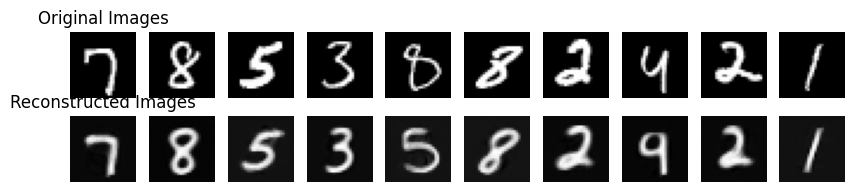

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model_dir = '../model/mae'

encoder.load_state_dict(torch.load(os.path.join(model_dir, 'encoder.pth')))
decoder.load_state_dict(torch.load(os.path.join(model_dir, 'decoder.pth')))

# 将模型设置为评估模式
encoder.eval()
decoder.eval()

# 加载MNIST测试数据集
test_dataset = datasets.MNIST(root='../datasets', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)

# 从数据加载器中获取一批数据
data_iter = iter(test_loader)
images, _ = next(data_iter)

# 将图像移动到设备上
images = images.to(device)

# 使用编码器和解码器
with torch.no_grad():
    encoded_imgs = encoder(images.view(-1, 28*28))
    decoded_imgs = decoder(encoded_imgs)

# 将图像移动回CPU
images = images.cpu()
decoded_imgs = decoded_imgs.cpu()

# 绘制原始图像和重建图像
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 2))
for i in range(10):
    axes[0, i].imshow(images[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
axes[0, 0].set_title('Original Images')
axes[1, 0].set_title('Reconstructed Images')